# Agent-Based Simulation: Unbalanced Flow Convergence 

In [1]:
import matplotlib.pyplot as plt
from pathlib import Path
import random 
import pandas as pd
from matplotlib.collections import LineCollection
import matplotlib as mpl
import numpy as np
from scipy import optimize as opt
from scipy import integrate as intg
from scipy.optimize import least_squares
from scipy.stats import beta
from scipy.stats import bernoulli
from scipy.stats import cumfreq, beta
from utils import simulate_game

%matplotlib inline
plt.style.use('../notebook.mplstyle')

SEED = 1 

## Exogenous Parameters


In [2]:
# Setting exogenous parameters
def reset_exog_params():
    global Bm, Bw, bm_vals, bw_vals, δ, Um, Uw, Fm, Fw, λm, λw
    Bm = 10
    Bw = 10
    bm_vals = range(1,Bm+1) 
    bw_vals = range(1,Bw+1)
    
    δ = 0.97
    Um = lambda θ : θ 
    Uw = lambda θ : θ
    Fm = beta(3,3)
    Fw = beta(3,3)
    λm = 20
    λw = 10

def exog_params():
    return (Bm, Bw, bm_vals, bw_vals, δ, Um, Uw, Fm, Fw, λm, λw)

## Two-Sided Search Equilibrium Conditions 


In [3]:
# Optimality conditions
def SSE(x): 
    # Endogenous Variables 
    μ = x[:Bm] 
    ω = x[Bm:Bm+Bw]   

    Pm = x[Bm+Bw:2*Bm+Bw]
    Pw = x[2*Bm+Bw:2*Bm+2*Bw]  

    Nm = x[2*Bm+2*Bw] 
    Nw = x[2*Bm+2*Bw+1]  
    
    τm = min(Nw/Nm, 1)
    τw = τm * (Nm/Nw) 
    αm = (τm*δ)/(1-δ*(1-τm))
    αw = (τw*δ)/(1-δ*(1-τw)) 

    # Initialising system of equilibrium equations
    E = np.empty(2*Bm + 2*Bw + 2) 

    # Initial condition for men 
    E[0] = (Um(μ[0]) 
            - αm * Um(μ[0]) * Fw.cdf(μ[0]) 
            - αm * intg.quad(lambda t: Um(t) * Fw.pdf(t), μ[0], 1)[0]) 
    
    # Intertemporal optimality conditions for men
    for b in range(1, Bm):
        E[b] = (Um(μ[b]) 
                - αm * Um(μ[b]) * Fw.cdf(μ[b]) 
                - αm * Um(μ[b-1])*(1-Fw.cdf(μ[b-1])) 
                - αm * intg.quad(lambda t : Um(t) * Fw.pdf(t), μ[b], μ[b-1])[0])
    
    # Initial condition for women     
    E[Bm] = (Uw(ω[0]) 
            - αw * Uw(ω[0]) * Fm.cdf(ω[0]) 
            - αw * intg.quad(lambda t: Uw(t) * Fm.pdf(t), ω[0], 1)[0])

    # Intertemporal optimality conditions for women
    for b in range(1, Bw):
        E[Bm+b] = (Uw(ω[b]) 
                - αw * Uw(ω[b]) * Fm.cdf(ω[b]) 
                - αw * Uw(ω[b-1])*(1-Fm.cdf(ω[b-1])) 
                - αw * intg.quad(lambda t : Uw(t) * Fm.pdf(t), ω[b], ω[b-1])[0]) 
                
    # Platform flow men
    E[Bm+Bw] = λm - (1-δ)*Nm - Nm*Pm[0]*δ*τm*(1-Fw.cdf(μ[0]))

    for b in range(0, Bm-1):
       E[Bm+Bw+b+1] = (Nm*Pm[b+1]*δ*τm*(1-Fw.cdf(μ[b+1]))
                    - Nm*Pm[b]*(1-δ) - Nm*Pm[b]*δ*τm*(1-Fw.cdf(μ[b])))

    E[2*Bm+Bw] = λm - Nm*Pm[Bm-1]*(1-δ) - Nm*Pm[Bm-1]*δ*τm*(1-Fw.cdf(μ[Bm-1]))

    # Platform flow women
    E[2*Bm+Bw+1] = λw - (1-δ)*Nw - Nw*Pw[0]*δ*τw*(1-Fm.cdf(ω[0]))  

    for b in range(0, Bw-1):
       E[2*Bm+Bw+2+b] = (Nw*Pw[b+1]*δ*τw*(1-Fm.cdf(ω[b+1]))
                      - Nw*Pw[b]*(1-δ) - Nw*Pw[b]*δ*τw*(1-Fm.cdf(ω[b])))

    E[2*Bm+2*Bw+1] = λw - Nw*Pw[Bw-1]*(1-δ) - Nw*Pw[Bw-1]*δ*τw*(1-Fm.cdf(ω[Bw-1])) 

    return E 

## Solving For Steady State Equilibria 

In [4]:
reset_exog_params()
μ_test = np.random.rand(Bm) 
ω_test = np.random.rand(Bw) 

Pm_test = np.random.rand(Bm)
Pw_test = np.random.rand(Bw) 

N_test = np.array([λm*(Bm+1), λw*(Bw+1)])

print('μ0: ', μ_test)
print('ω0: ', ω_test)
print('')

x_start = np.concatenate((μ_test, ω_test, Pm_test, Pw_test, N_test), axis=None) 
solution = opt.root(SSE, x_start) 

μ0:  [0.05907    0.60927978 0.40942325 0.71380238 0.06478662 0.33109213
 0.91603553 0.43074241 0.73939905 0.41848602]
ω0:  [0.33328295 0.73790606 0.27853533 0.96023953 0.0178391  0.3324402
 0.91996379 0.12486795 0.43229653 0.6765563 ]



In [5]:
μ_star = solution.x[:Bm]
ω_star = solution.x[Bm:Bm+Bw]
loss = round(np.sum(SSE(solution.x)**2), 3)
print('μ* ', μ_star) 
print('ω* ', ω_star) 
print('Loss: ',loss) 
print('')

Pm = solution.x[Bm+Bw:2*Bm+Bw]
Pw = solution.x[2*Bm+Bw:2*Bm+2*Bw]  

Nm = solution.x[2*Bm+2*Bw] 
Nw = solution.x[2*Bm+2*Bw+1]

# Normalized masses 
nm = [(Pm[b]*Nm)/(Nm+Nw) for b in range(Bm)]
nw = [(Pw[b]*Nw)/(Nm+Nw) for b in range(Bw)]

print('Masses: ', round((Nm)/(Nm+Nw),3), round((Nw)/(Nm+Nw),3))
print('Unity Sum check:', round(sum(Pm),3), round(sum(Pw),3))
print('')

τm = min(Nw/Nm, 1)
τw = τm * (Nm/Nw) 
αm = (τm*δ)/(1-δ*(1-τm))
αw = (τw*δ)/(1-δ*(1-τw)) 
print('Tightness: ', round(τm,3), round(τw,3))
print('Alphas: ', round(αm,3), round(αw,3)) 
print('')

ρm = sum([(1 - Fw.cdf(μ_star[b]))*Pm[b] for b in range(Bm)])
ρw = sum([(1 - Fm.cdf(ω_star[b]))*Pw[b] for b in range(Bw)])
print('Average Swipe Rate: ', round(ρm, 3), round(ρw, 3))

μ*  [0.56258451 0.47202629 0.41132631 0.36474793 0.32672713 0.29458043
 0.26678558 0.24238559 0.22073373 0.2013686 ]
ω*  [0.66366994 0.59515949 0.54890106 0.51301625 0.4833236  0.45781311
 0.43534878 0.41521996 0.3969497  0.38020096]
Loss:  0.0

Masses:  0.744 0.256
Unity Sum check: 1.0 1.0

Tightness:  0.345 1.0
Alphas:  0.918 0.97

Average Swipe Rate:  0.774 0.491


## Single Batch Agent-Based Simulation

In [6]:
reset_exog_params()   
T = 300
simulation = simulate_game(T, μ_star, ω_star, exog_params())
batch = pd.DataFrame(simulation)
batch.head(5)

,batch,id,time,birth,sex,attractiveness,budget,observed_rate,true_rate,matches,rs_given,rs_received
0,0,2,0,0,Male,0.179054,9,1.0,1.0,0,1,0
1,0,1,0,0,Male,0.743557,9,1.0,1.0,1,1,1
2,0,6,0,0,Male,0.406374,9,1.0,1.0,1,1,1
3,0,14,0,0,Male,0.388185,9,1.0,1.0,1,1,1
4,0,17,0,0,Male,0.754757,9,1.0,1.0,1,1,1


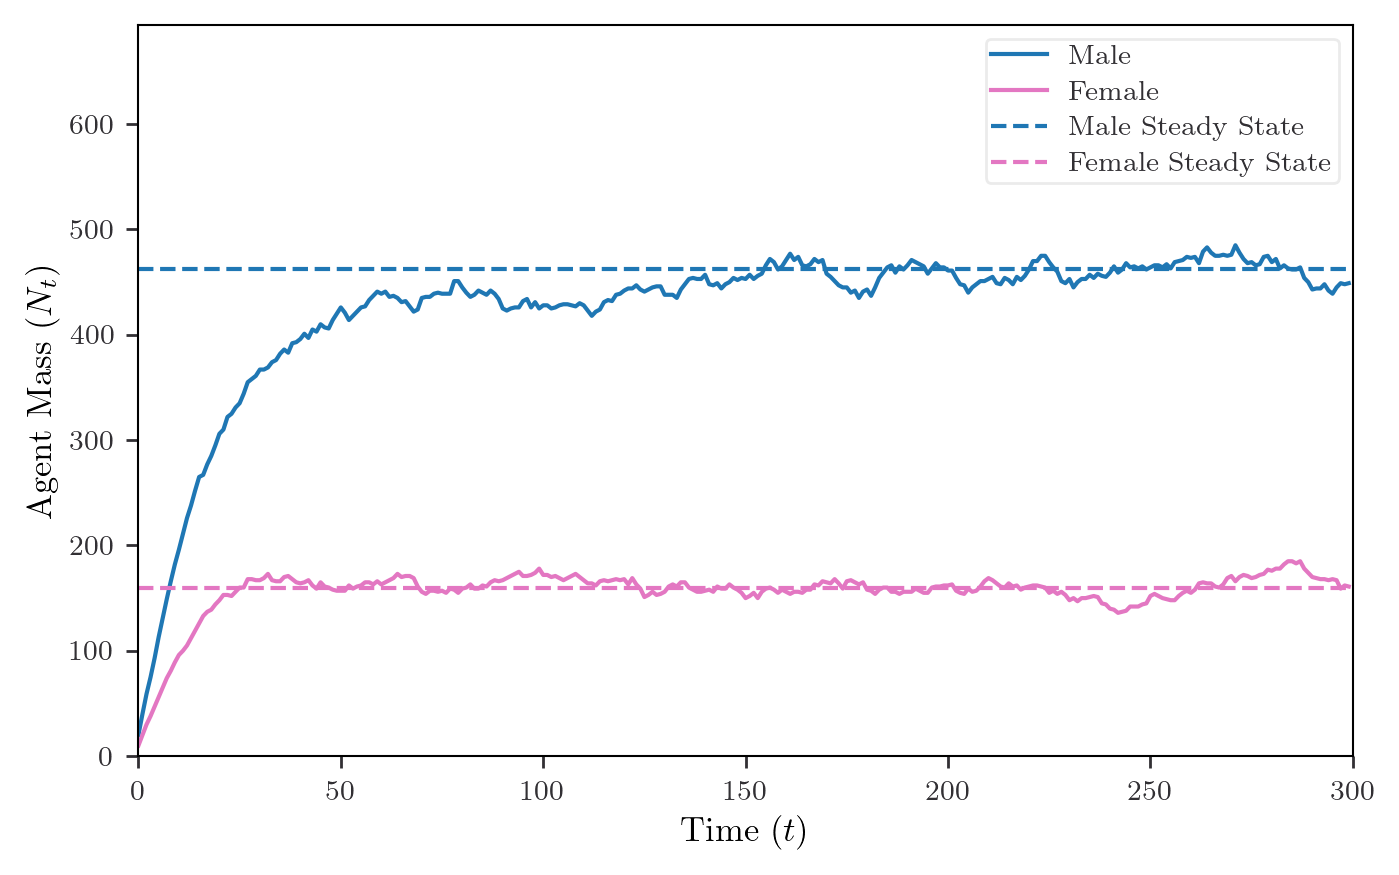

In [7]:
mass_by_sex = batch.groupby(['time', 'sex'], as_index=False).size() 
Nm_series = mass_by_sex[mass_by_sex.sex=='Male']['size']
Nw_series = mass_by_sex[mass_by_sex.sex=='Female']['size']

fig, ax = plt.subplots()
ax.set_xlim(0,T)
ax.set_ylim(0, 1.5*max(Nm,Nw))  
ax.plot(range(0,T), Nm_series, color='tab:blue', label='Male') 
ax.plot(range(0,T), Nw_series, color='tab:pink', label='Female') 

ax.axhline(y=Nm, color='tab:blue', linestyle='--', label='Male Steady State')
ax.axhline(y=Nw, color='tab:pink', linestyle='--', label='Female Steady State')

ax.set(xlabel=r'Time ($t$)', ylabel=r'Agent Mass ($N_t$)')
ax.legend() 
plt.show() 

## Multiple Batch Agent-Based Simulation

In [8]:
simulations = []
batches = 10
for i in range(batches):
    game = simulate_game(T, μ_star, ω_star, exog_params(), i)
    simulations += game
    
data = pd.DataFrame(simulations) 

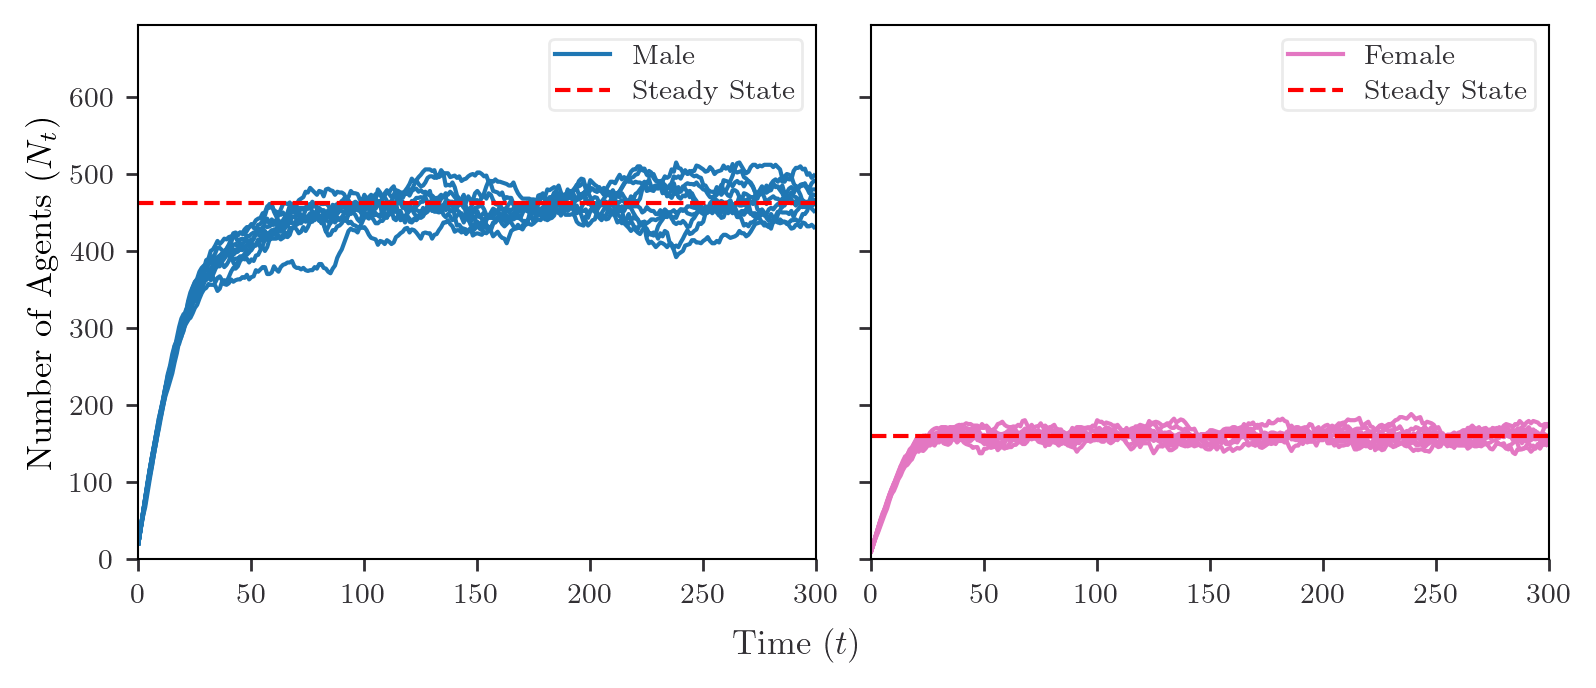

In [10]:
mass = data.groupby(['batch','time','sex'], as_index=False).size() 

fig, axs = plt.subplots(1,2, figsize=(6.267704441677044, 2.6368271881975483), constrained_layout=True, sharey=True)
axs[0].set_xlim(0,T)  
axs[1].set_xlim(0,T)  
axs[0].set_ylim(0, 1.5*max(Nm,Nw))

for i in range(batches):
    if i==0:
        axs[0].plot(range(0,T), mass[(mass.batch==i)&(mass.sex=='Male')]['size'], color='tab:blue', label='Male')   
        axs[1].plot(range(0,T), mass[(mass.batch==i)&(mass.sex=='Female')]['size'], color='tab:pink', label='Female') 
    else:
        axs[0].plot(range(0,T), mass[(mass.batch==i)&(mass.sex=='Male')]['size'], color='tab:blue')   
        axs[1].plot(range(0,T), mass[(mass.batch==i)&(mass.sex=='Female')]['size'], color='tab:pink')

    
axs[0].set(ylabel=r'Number of Agents ($N_t$)')

axs[0].axhline(y=Nm, color='r', linestyle='--', label='Steady State')
axs[1].axhline(y=Nw, color='r', linestyle='--', label='Steady State')

axs[0].legend()
axs[1].legend()

fig.supxlabel('Time ($t$)', size=10) 
#plt.savefig('../../figures/abm-conv-imbalanced.png', bbox_inches='tight')
plt.show()